# 9. Support vector machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_range(Xx, Xy):
    xmin, xmax = Xx.min() - 0.1, Xx.max() + 0.1
    ymin, ymax = Xy.min() - 0.1, Xy.max() + 0.1
    if xmax - xmin < ymax - ymin:
        xmid = (xmax + xmin) / 2
        xmin = xmid - (ymax - ymin) / 2
        xmax = xmid + (ymax - ymin) / 2
    else:
        ymid = (ymax + ymin) / 2
        ymin = ymid - (xmax - xmin) / 2
        ymax = ymid + (xmax - xmin) / 2
    return ((xmin, xmax), (ymin, ymax))

def init_graph(X, Y, dpi=100, figsize=(6,6)):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == -1)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')

def draw_line(ax, wx, wy, b, ls, name='', color='tab:gray'):
    def f(x, wx, xy, b):
        return - wx / wy * x - b / wy
    
    x = np.array(ax.get_xlim())
    y = f(x, wx, wy, b)
    ax.plot(x, y, color=color, ls=ls, label=f'{name}')

def draw_margins(ax, wx, wy, Xx, Xy, svn, svp, s=None):
    length = np.sqrt(wx ** 2 + wy ** 2)
    margin = 1 / length

    for i in svn:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:blue')
        ax.plot([x, x + wx * margin / length], [y, y + wy * margin / length], ls=':', color='tab:blue')
        
    for i in svp:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:red')
        ax.plot([x, x - wx * margin / length], [y, y - wy * margin / length], ls=':', color='tab:red')

def plot_support_vectors(ax, X, Y, svs, s=None):
    for i in svs:
        color = 'tab:red' if Y[i] == 1 else 'tab:blue'
        ax.scatter([X[i][0]], [X[i][1]], s=s, facecolors='none', edgecolors=color)

def draw_heatmap(ax, fig, X, Y, model, step=1, N=1024):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T
    C = model.decision_function(XY).reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

## 9.1 Linear model

In [3]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)
Y = 2 * Y - 1

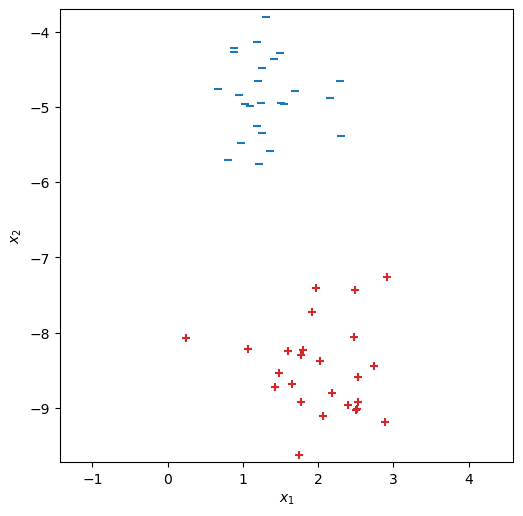

In [4]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plt.show()